# **University Life in Udine**

Are you a student wishing to study in Udine? Here's everything you need to know.

### **Some info about the notebook**

In this notebook there will be content designed specifically for users, others for programmers.

This distinction is made explicit by the use of the following icons:
- User 🧍‍♂️
- Programmer 👨‍💻

TODO: inserire qui la spiegazione generale del notebook.

---

## **Setup** 👨‍💻 

We import the necessary libraries for the notebook to correctly work.

In [43]:
import gpxpy
import pandas as pd
from datetime import datetime,timezone,timedelta
import geopandas as gpd
from geopy.geocoders import Nominatim
import movingpandas as mpd
import contextily as ctx
import os
import sys

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import custom modules
sys.path.insert(0, os.path.abspath('../')) # need to pass absolute path in nb

print("> Setup Completed")

> Setup Completed


---

### Functions

TODO: move them to utility .py file

In [44]:
def read_gpx(path):
    """
    returns a gpx object, given its local path
    """
    gpx_file = open(path, 'r', encoding='UTF-8')
    return gpxpy.parse(gpx_file)


def print_gpx_info(gpx_file):
    """
    prints info about creator and structure of gpx file
    """
    for count_t, track in enumerate(gpx_file.tracks):
        print("Creator:", gpx_file.creator)
        #print("\nTracks, Segments and Points")
        print("> Track", count_t)
        for count_s, segment in enumerate(track.segments):
            print("  > Segment", count_s, "has", len(segment.points), "points")


def create_geodf_from_segment(gpx_file, track_idx, segment_idx):
    """
    Input
        > gpx_file
        > track_idx     index of track (first layer)
        > segment_idx   index of segment (second layer)

    Output
        > pandas dataframe with information of required segment
    """
    data = []
    for point_idx, point in enumerate(gpx_file.tracks[track_idx].segments[segment_idx].points):
        data.append([
            point.longitude, 
            point.latitude,
            point.elevation,
            point.time]
            ) 

    columns_name = ['longitude', 'latitude', 'altitude', 'time'] 
    gpx_dataframe = pd.DataFrame(data, columns=columns_name)

    gpx_dataframe['time'] = gpx_dataframe['time'].apply(lambda x: x.replace(tzinfo=None))

    geo_df = gpd.GeoDataFrame(
        gpx_dataframe, 
        crs = 4326,
        geometry = gpd.points_from_xy(gpx_dataframe.longitude, gpx_dataframe.latitude, gpx_dataframe.altitude)
        )

    return geo_df


def get_travel_time(df):
    """
    Given a geodf with a 'time' column, it prints the total time required
    Note: the 'time' column MUST be sorted in ascending order
    """
    # obtain start and end times
    start = df["time"][0]
    end = df["time"][len(df["time"])-1]

    # get travel time
    travel_time = end - start
    travel_time_hours = str(timedelta(seconds=travel_time.seconds))

    # show res
    print_travel_time = travel_time_hours.split(':')
    print("Travel Time: %sh %sm" % (print_travel_time[0], print_travel_time[1]))


def get_altitude(df):
    """
    Given a geodf with an 'altitude' column, it prints the min and max value present
    """
    min_alt = min(df["altitude"])
    max_alt = max(df["altitude"])
    print("Minimum altitude: %s meters\nMaximum altitude: %s meters" % (min_alt, max_alt))


def get_start_end_locations(df):

    # setup Nominatin
    geolocator = Nominatim(user_agent="udine_project")

    # obtain lat and lon for start point point
    lat_start = df["geometry"][0].y
    lon_start = df["geometry"][0].x
    latlon_start = str(lat_start) + "," + str(lon_start)

    # obtain lat and lon for end point
    last_idx = len(df["geometry"]) - 1
    lat_end = df["geometry"][last_idx].y
    lon_end = df["geometry"][last_idx].x
    latlon_end = str(lat_end) + "," + str(lon_end)

    # obtain info and print them
    start_location = geolocator.reverse(latlon_start)
    end_location = geolocator.reverse(latlon_end)

    print("Start Location:", start_location[0])
    print("End Location:", end_location[0])
    

## Test con un file .gpx

In [45]:
# import gpx file
path = "../data/strava/udine_trekking_parco_cormor_strava_to_gpx.gpx"
udine_trekking_cormor = read_gpx(path)

# show info about tracks, segments and points
print_gpx_info(udine_trekking_cormor)

Creator: https://www.mapstogpx.com/strava
> Track 0
  > Segment 0 has 754 points


In [46]:
# create dataframe from selected segment
udine_trekking_cormor_geodf = create_geodf_from_segment(udine_trekking_cormor, 0, 0)
udine_trekking_cormor_geodf

,longitude,latitude,altitude,time,geometry
0,13.214740,46.072182,115.1,2021-12-26 17:46:01,POINT Z (13.21474 46.07218 115.10000)
1,13.214760,46.072172,115.1,2021-12-26 17:46:02,POINT Z (13.21476 46.07217 115.10000)
2,13.214810,46.072143,115.1,2021-12-26 17:46:04,POINT Z (13.21481 46.07214 115.10000)
3,13.214862,46.072117,115.2,2021-12-26 17:46:06,POINT Z (13.21486 46.07212 115.20000)
4,13.214917,46.072090,115.2,2021-12-26 17:46:08,POINT Z (13.21492 46.07209 115.20000)
...,...,...,...,...,...
749,13.214889,46.072088,115.2,2021-12-26 19:02:24,POINT Z (13.21489 46.07209 115.20000)
750,13.214764,46.072137,115.1,2021-12-26 19:02:28,POINT Z (13.21476 46.07214 115.10000)
751,13.214667,46.072192,115.1,2021-12-26 19:02:32,POINT Z (13.21467 46.07219 115.10000)
752,13.214551,46.072258,115.0,2021-12-26 19:02:37,POINT Z (13.21455 46.07226 115.00000)


In [47]:
get_travel_time(udine_trekking_cormor_geodf)

Travel Time: 1h 16m


In [48]:
get_altitude(udine_trekking_cormor_geodf)

Minimum altitude: 93.7 meters
Maximum altitude: 115.3 meters


In [49]:
get_start_end_locations(udine_trekking_cormor_geodf)

Start Location: 78, Viale Leonardo da Vinci, Borgo Villalta, Villaggio del Sole, Udine, Friuli-Venezia Giulia, 33100, Italia
End Location: 82, Viale Leonardo da Vinci, Borgo Villalta, Villaggio del Sole, Udine, Friuli-Venezia Giulia, 33100, Italia


In [50]:
trajectory = mpd.Trajectory(udine_trekking_cormor_geodf, traj_id="test", t="time")

<AxesSubplot:>

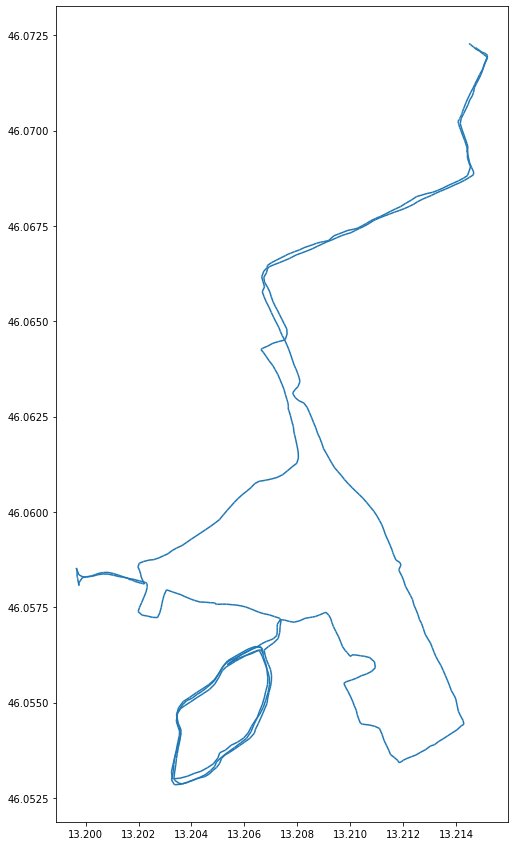

In [51]:
trajectory.plot(
    figsize=(15,15)
)

In [52]:
# import data on Italian municipalities
italy_municipalities_path = "../data/Com01012021_g/Com01012021_g_WGS84.shp"
italy_municipalities = gpd.read_file(italy_municipalities_path)

# save Udine and the municipalities in the province of Udine
udine_geodf = italy_municipalities.loc[italy_municipalities["COMUNE"] == "Udine"]
udine_mun_geodf = italy_municipalities.loc[italy_municipalities["COD_PROV"] == 30]

<AxesSubplot:>

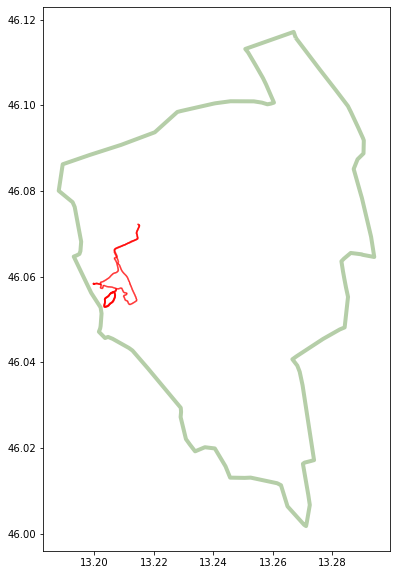

In [60]:
base = udine_geodf.boundary.to_crs(epsg=4326).plot(
    figsize=(10, 10),
    color="#B5CEA8",
    linewidth=4
    )

trajectory.plot(
    ax = base,
    color="red", 
    figsize=(9, 9)
    )

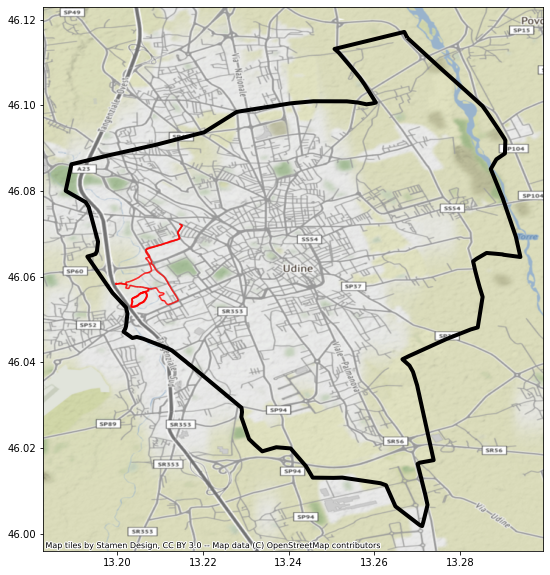

In [62]:
base = udine_geodf.boundary.to_crs(epsg=4326).plot(
    figsize=(10, 10),
    color="black",
    linewidth=4
    )

trajectory.plot(
    ax = base,
    color="red"
    )

# add the basemap to the base plot
ctx.add_basemap(
    base,crs = udine_geodf.to_crs(epsg=4326).crs.to_string(),
    source = ctx.providers.Stamen.Terrain
    )